In [1]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import pickle

import joblib


#forecaster = gas_forecaster.ModelForecaster

with open('train_y_df.pkl', 'rb') as f:
    train_y_df = pickle.load (f)
with open('train_df.pkl', 'rb') as f:
    train_df = pickle.load (f)
with open('test_y_df.pkl', 'rb') as f:
    test_y_df = pickle.load (f)
with open('test_df.pkl', 'rb') as f:
    test_df = pickle.load (f)


#unskalierte Werte
with open('unscaled_train_y_df.pkl', 'rb') as f:
    unscaled_train_y_df = pickle.load (f)
with open('unscaled_train_final_df.pkl', 'rb') as f:
    unscaled_train_final_df = pickle.load (f)
with open('unscaled_test_y.pkl', 'rb') as f:
    unscaled_test_y_df = pickle.load (f)
with open('unscaled_test_final_df.pkl', 'rb') as f:
    unscaled_test_final_df = pickle.load (f)
with open('diff_info.pkl', 'rb') as f:
    diff_info = pickle.load(f)

"""train_diff_order = diff_info['train_diff_order']
train_y_diff_order = diff_info['train_y_diff_order']
train_startwerte = diff_info['train_startwerte']
train_y_startwert = diff_info['train_y_startwert']"""

min_max_scaler = joblib.load('min_max_scaler.pkl')
y_min_max_scaler = joblib.load('y_min_max_scaler.pkl')

X = train_df
y = train_y_df



## EBM mit GridSearch (Test)


In [ ]:
# Feature-Auswahl
selected_features_cb = ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']


X_train = train_df[selected_features_cb]
y_train = train_y_df.values.ravel()
X_test = test_df[selected_features_cb]
y_test = test_y_df.values.ravel()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# Parametergitter
param_grid = {
    'max_bins': [256, 512],
    'interactions': [0, 10, 20],
    'outer_bags': [8, 16],
    'inner_bags': [0, 4]
}

# GridSearchCV
ebm = ExplainableBoostingRegressor(random_state=42)
grid_search = RandomizedSearchCV(
    estimator=ebm,
    param_distributions=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_iter=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Training
grid_search.fit(X_train, y_train)
best_ebm = grid_search.best_estimator_

# Vorhersage
y_pred_scaled = best_ebm.predict(X_test)
y_pred = y_min_max_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred))
r2 = r2_score(y_holdout_rescaled, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Echte Werte', color='black')
plt.plot(test_y_df.index, y_pred, label='EBM-Prognose', linestyle='--', color='green')
plt.title('EBM mit TimeSeriesSplit und RandomizedSearchCV')
plt.xlabel('Zeit')
plt.ylabel('Gaspreis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


TypeError: RandomizedSearchCV.__init__() missing 2 required positional arguments: 'estimator' and 'param_distributions'

## EBM default

### with gasprice

MAE: 9.0416
RMSE: 13.2111
R²: -3.6022


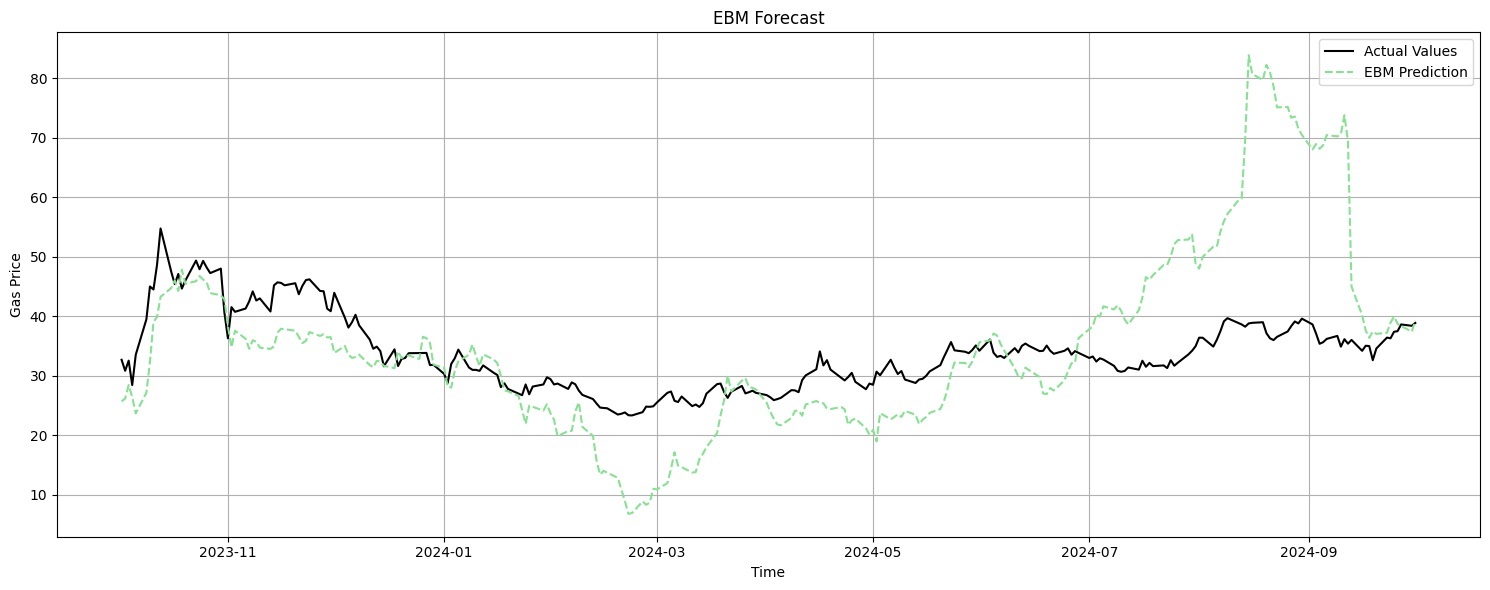

In [2]:
# Feature-Auswahl
selected_features_cb = ['S-Gas DA D', 'N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']

X_train = train_df[selected_features_cb]
y_train = train_y_df.values.ravel()
X_test = test_df[selected_features_cb]
y_test = test_y_df.values.ravel()

# Modell direkt mit festen Parametern initialisieren
ebm = ExplainableBoostingRegressor(interactions=20)


# Training
ebm.fit(X_train, y_train)

# Vorhersage
y_pred_scaled = ebm.predict(X_test)
y_pred = y_min_max_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred))
r2 = r2_score(y_holdout_rescaled, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred, label='EBM Prediction', linestyle='--', color='#84E291')
plt.title('EBM Forecast')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


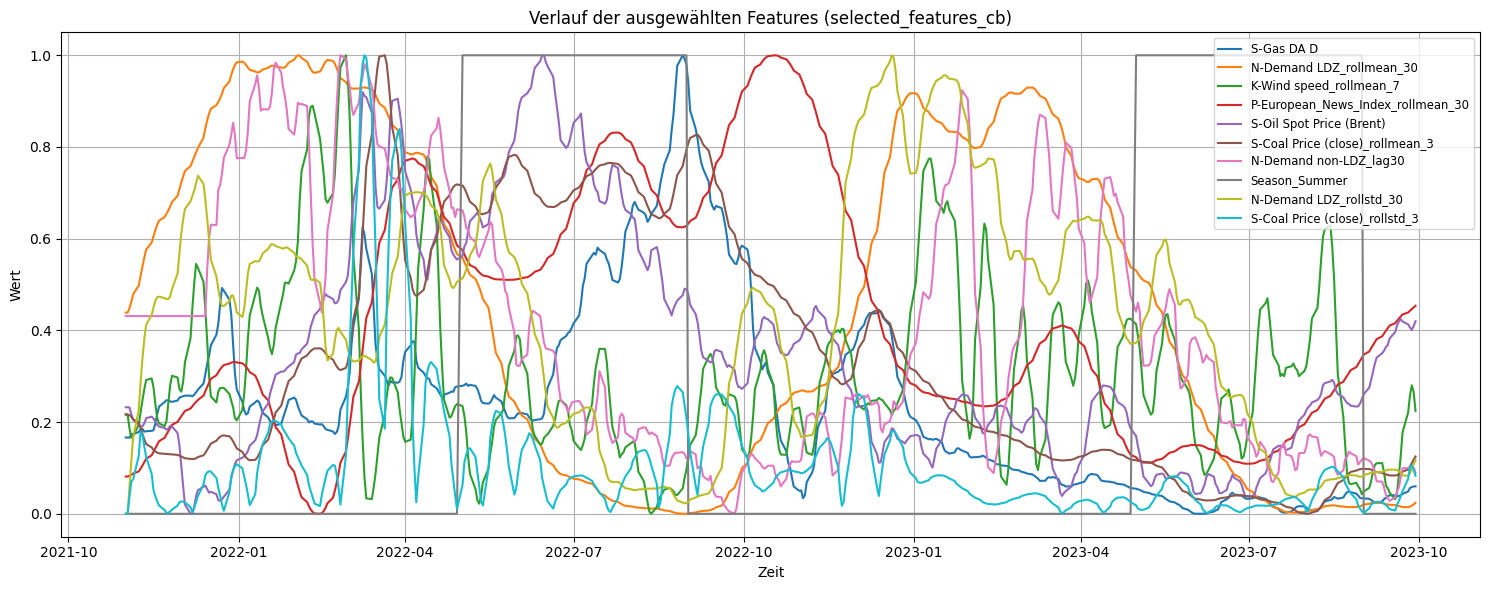

In [5]:
plt.figure(figsize=(15, 6))

for col in selected_features_cb:
    plt.plot(train_df.index, train_df[col], label=col)

plt.title("Verlauf der ausgewählten Features (selected_features_cb)")
plt.xlabel("Zeit")
plt.ylabel("Wert")
plt.legend(loc="upper right", fontsize="small")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# --- Hoch korrelierte Paare explizit anzeigen ---
threshold = 0.92
corr_matrix = train_df[selected_features_cb].corr().abs()

# Nur obere Matrixhälfte
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Paare extrahieren
high_corr_pairs = [
    (col1, col2, upper.loc[col1, col2])
    for col1 in upper.columns
    for col2 in upper.columns
    if col1 != col2 and upper.loc[col1, col2] > threshold
]

# Ausgabe
print("Hoch korrelierte Feature-Paare (> 0.92):")
for col1, col2, val in high_corr_pairs:
    print(f"{col1} ↔ {col2}: r = {val:.3f}")


Hoch korrelierte Feature-Paare (> 0.92):


In [3]:
from interpret import show
ebm_global = ebm.explain_global()
show (ebm_global)

<!-- http://127.0.0.1:7001/2017864812352/ -->

### without gasprice

MAE: 44.4968
RMSE: 54.7693
R²: -78.0970


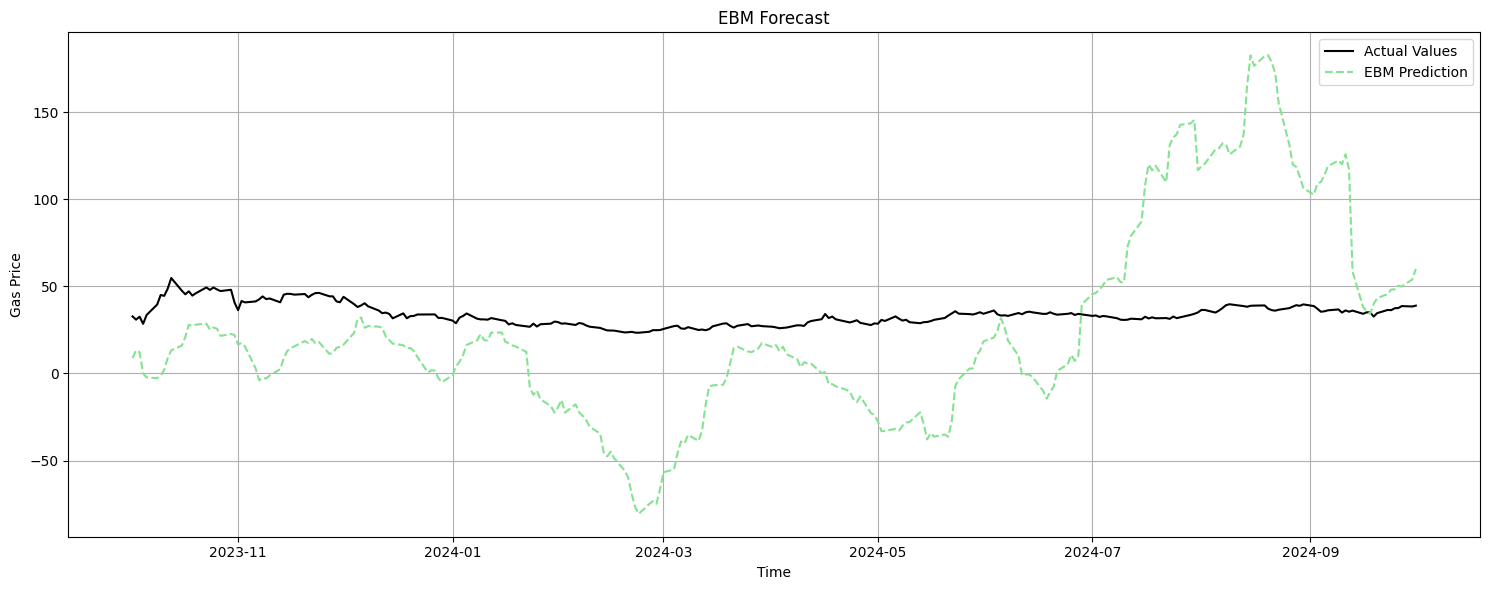

In [3]:
# Feature-Auswahl
selected_features_cb = ['N-Demand LDZ_rollmean_30', 'K-Wind speed_rollmean_7', 'P-European_News_Index_rollmean_30', 'S-Coal Price (close)_lag1', 'Season_Winter', 'P-GPR_rollmean_30', 'N-Demand LDZ_rollstd_30', 'P-European_News_Index_lag1', 'P-GPR_lag1', 'S-Coal Price (close)_rollmean_7', 'S-Coal Price (close)_rollstd_3']


X_train = train_df[selected_features_cb]
y_train = train_y_df.values.ravel()
X_test = test_df[selected_features_cb]
y_test = test_y_df.values.ravel()

# Modell direkt mit festen Parametern initialisieren
ebm = ExplainableBoostingRegressor()


# Training
ebm.fit(X_train, y_train)

# Vorhersage
y_pred_scaled = ebm.predict(X_test)
y_pred = y_min_max_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

# Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred))
r2 = r2_score(y_holdout_rescaled, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Actual Values', color='black')
plt.plot(test_y_df.index, y_pred, label='EBM Prediction', linestyle='--', color='#84E291')
plt.title('EBM Forecast')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Mit eigener FS (Test)

In [22]:


# Starte mit allen Features
current_features = train_df.columns.tolist()
best_mae = float('inf')
best_features = current_features.copy()
history = []

while len(current_features) > 1:
    # Schrittweise EBM trainieren
    ebm = ExplainableBoostingRegressor(random_state=42)
    ebm.fit(train_df[current_features], train_y_df.values.ravel())

    # Vorhersage und Metriken berechnen
    y_pred_scaled = ebm.predict(test_df[current_features])
    y_pred = y_min_max_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    y_true = y_min_max_scaler.inverse_transform(test_y_df.values.reshape(-1, 1)).ravel()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    history.append((len(current_features), mae, rmse, r2, current_features.copy()))

    # Beste Konfiguration speichern
    if mae < best_mae:
        best_mae = mae
        best_features = current_features.copy()
    else:
        break  # Stoppen, wenn es nicht mehr besser wird

    # Wichtige Features ermitteln
    global_exp = ebm.explain_global()

    importance_dict = {
        global_exp.data(i)['feature']: global_exp.data(i)['scores']
        for i in range(len(global_exp.data()))
    }
    avg_importance = {
        feat: np.mean(np.abs(scores)) for feat, scores in importance_dict.items()
    }

    sorted_features = sorted(avg_importance.items(), key=lambda x: x[1])
    weakest_feature = sorted_features[0][0]
    current_features.remove(weakest_feature)


# Bestes Modell trainieren und plotten
print(f"Bestes Feature-Set ({len(best_features)} Features):")
print(best_features)

# Finales Modell mit besten Features
final_ebm = ExplainableBoostingRegressor(random_state=42)
final_ebm.fit(train_df[best_features], train_y_df.values.ravel())
y_pred_scaled = final_ebm.predict(test_df[best_features])
y_pred = y_min_max_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = y_min_max_scaler.inverse_transform(test_y_df.values.reshape(-1, 1)).ravel()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Plotten
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_true, label='Echte Werte', color='black')
plt.plot(test_y_df.index, y_pred, label='EBM-Prognose (beste Feature-Subset)', linestyle='--', color='green')
plt.title('EBM-Vorhersage nach iterativer Feature-Reduktion')
plt.xlabel('Zeit')
plt.ylabel('Gaspreis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Visualisierung mit interpret
# show(final_ebm.explain_global(name='Final EBM'))


KeyError: 'feature'

In [57]:
model_filename = 'ebm_0705.pkl'

# Speichern des Modells
with open(model_filename, 'wb') as file:
    pickle.dump(best_ebm, file)

print(f"\nBestes Modell wurde unter '{model_filename}' gespeichert.")


Bestes Modell wurde unter 'ebm_0705.pkl' gespeichert.


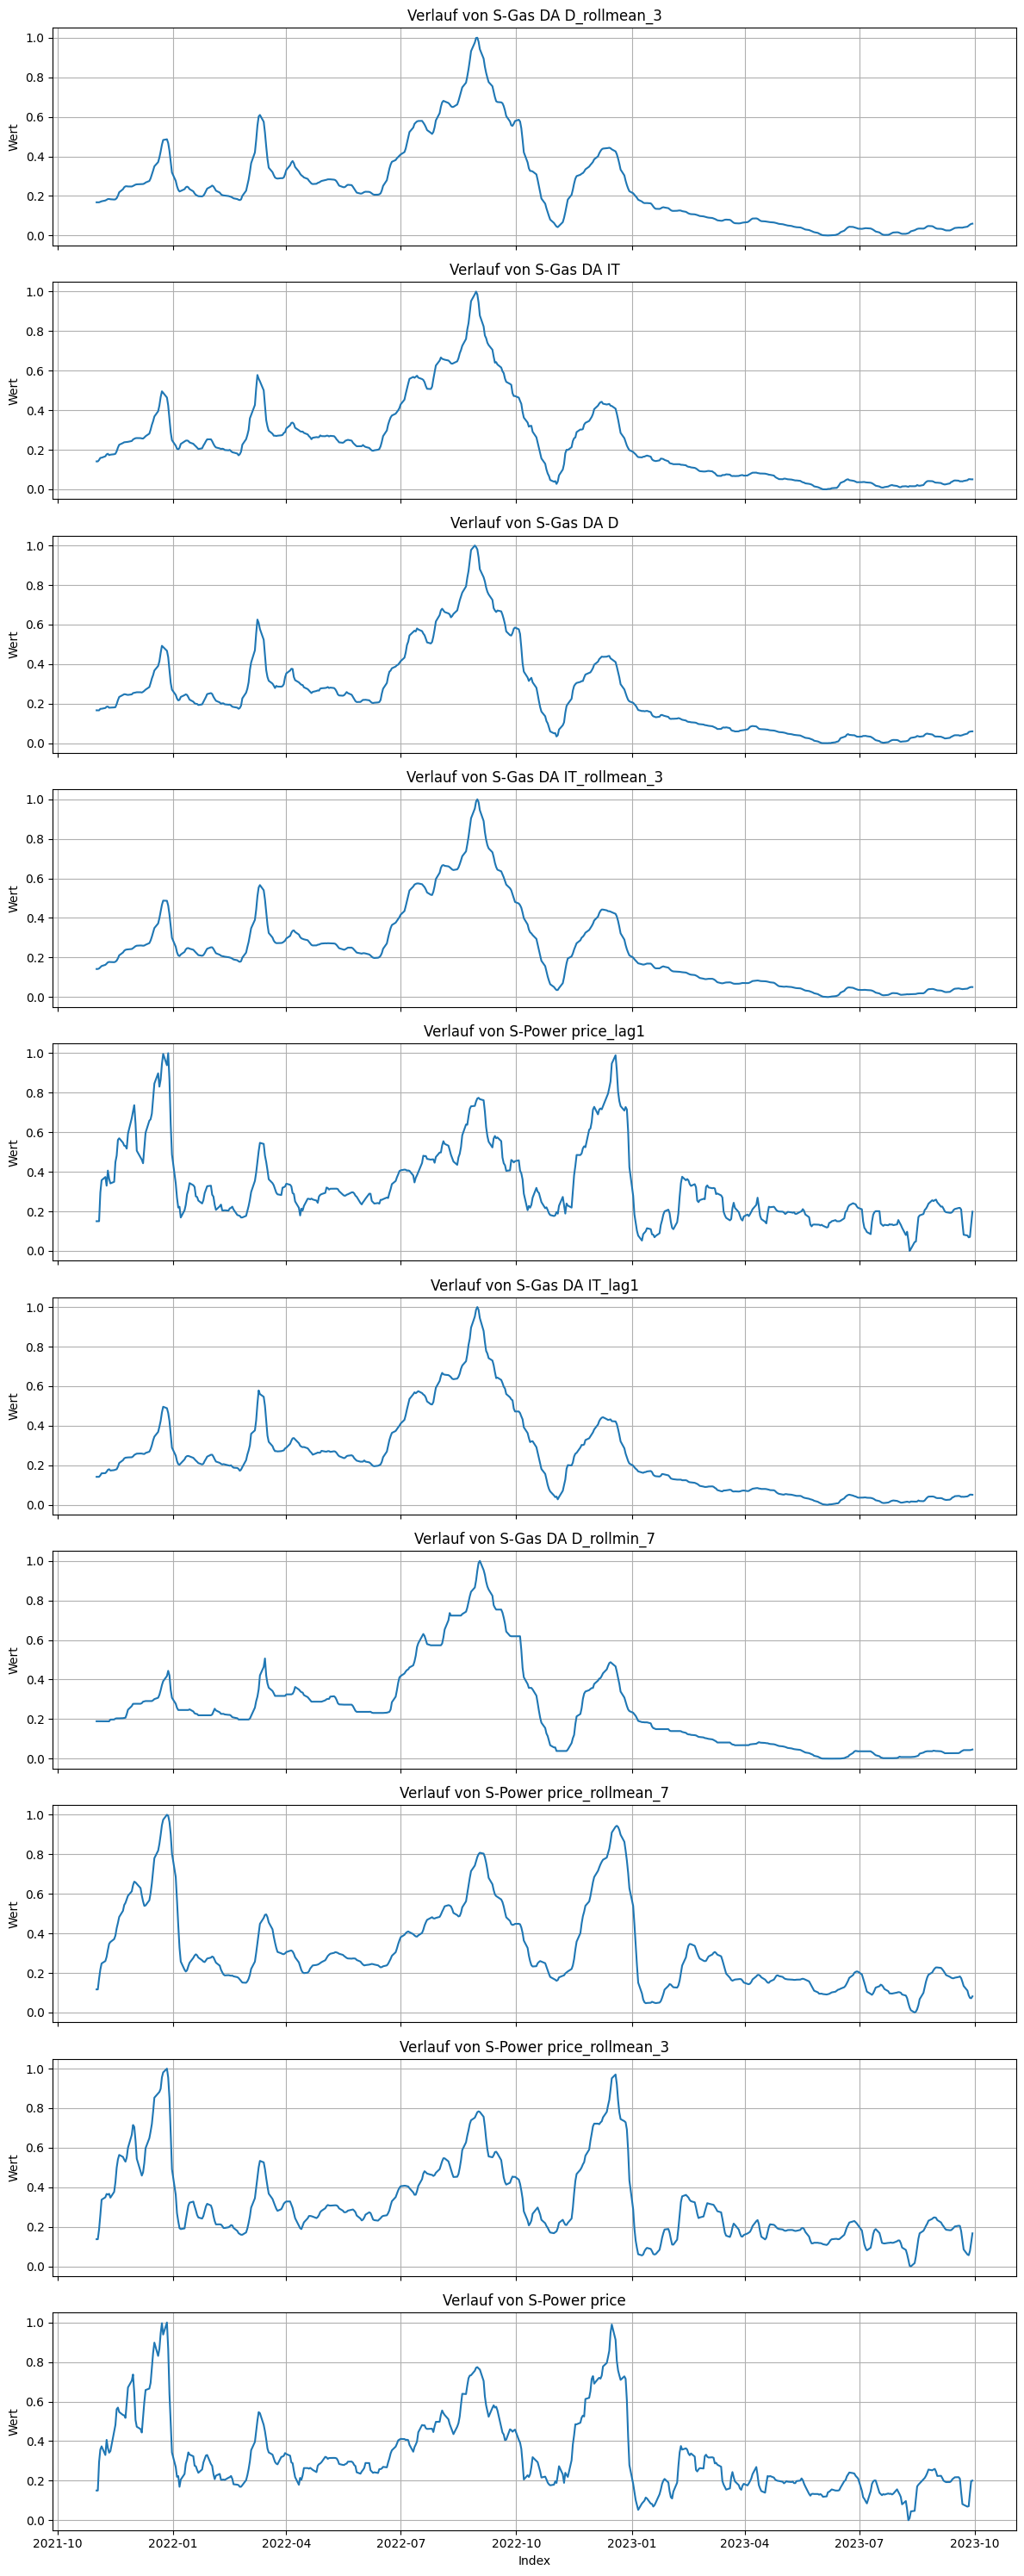

In [74]:
n = len(selected_features_cb)

# Größe des Plots automatisch anpassen
fig, axes = plt.subplots(n, 1, figsize=(12, 3 * n), sharex=True)

if n == 1:
    axes = [axes]  # Falls nur ein Feature vorhanden ist

for i, feature in enumerate(selected_features_cb):
    axes[i].plot(train_df[feature])
    axes[i].set_title(f"Verlauf von {feature}")
    axes[i].set_ylabel("Wert")
    axes[i].grid(True)

axes[-1].set_xlabel("Index")
plt.tight_layout()
plt.show()

### SFS mit Skalierung

In [36]:

# 1) Zeitreihen-Cross-Validation definieren
"""tscv = TimeSeriesSplit(n_splits=4)

# 2) Basismodell für Feature Selection: Explainable Boosting Machine
ebm_base = ExplainableBoostingRegressor(random_state=42)

# 3) Sequential Forward Selection mit EBM
sfs_ebm = SequentialFeatureSelector(
    estimator=ebm_base,
    n_features_to_select=8,
    direction='forward',
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1
)
sfs_ebm.fit(train_df, train_y_df.values.ravel())

# 

# 5) Ausgewählte Features extrahieren
selected_features_ebm = list(sfs_ebm.get_feature_names_out())
print("Ausgewählte Features (EBM):", selected_features_ebm)"""
selected_features_ebm = ['S-Gas DA D', 'K-Wind speed_rollmin_7', 'N-Demand LDZ_lag7', 'N-Demand LDZ_rollstd_30', 'S-Gas DA D_rollmean_3', 'S-Gas DA D_rollmin_7', 'S-Gas DA D_rollmax_7', 'S-Oil Spot Price (Brent)_lag1', 'S-Oil Spot Price (Brent)_rollmean_3', 'S-Oil Spot Price (Brent)_rollmax_7', 'S-CO2 Price_rollstd_30', 'Season_Summer', 'Season_Winter']
# 6) Trainings- und Testdaten mit selektierten Features
X_train_ebm = train_df[selected_features_ebm]
X_test_ebm  = test_df[selected_features_ebm]
y_train = train_y_df.values.ravel()
y_test  = test_y_df.values.ravel()


param_dist_ebm_angepasst = {
    'max_bins': [256, 512],
    'max_leaves': [32, 64, 128],         # Deutlich erhöht
    'interactions': [0, 1, 3],            # Wieder erhöht
    'outer_bags': [16, 20, 24],
    'inner_bags': [8, 10, 12],
    'learning_rate': [0.0001, 0.0005, 0.001], # Leicht erhöht
    'max_rounds': [250, 350, 450],
    'early_stopping_rounds': [15, 20, 25], # Leicht reduziert
    'validation_size': [0.1, 0.2]
}

random_search = RandomizedSearchCV(
    estimator=ExplainableBoostingRegressor(random_state=42),
    param_distributions=param_dist_ebm_angepasst,
    n_iter=20,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_ebm, y_train)

# Bestes Modell:
best_ebm = random_search.best_estimator_
print("Beste Hyperparameter (EBM):", random_search.best_params_)

y_pred_scaled = best_ebm.predict(X_test_ebm)
y_pred = y_min_max_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_holdout_rescaled = y_min_max_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

# 10) Performance-Metriken
mae = mean_absolute_error(y_holdout_rescaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_holdout_rescaled, y_pred))
r2 = r2_score(y_holdout_rescaled, y_pred)

print(f"MAE (EBM): {mae:.4f}")
print(f"RMSE (EBM): {rmse:.4f}")
print(f"R² (EBM): {r2:.4f}")

# 11) Plot der Prognose
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_holdout_rescaled, label='Echte Werte', color='black')
plt.plot(test_y_df.index, y_pred, label='EBM-Prognose', linestyle='--', color='green')
plt.title('EBM-Vorhersage mit SFS und Hyperparameter-Tuning')
plt.xlabel('Zeit')
plt.ylabel('Gaspreis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

### Ohne Skalierung

Durch CatBoost Feature Importance ausgewählte Features: ['S-Gas DA D', 'S-Gas DA D_rollmean_3', 'S-Gas DA D_rollmean_7', 'S-Gas DA D_lag1', 'S-Gas DA D_rollmax_7', 'S-Power price_lag1', 'P-EXY Average _lag1', 'K-Wind speed_rollstd_30', 'P-GPR_rollmean_30', 'S-Power price_rollmean_3']
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Beste Hyperparameter (EBM): {'validation_size': 0.1, 'outer_bags': 24, 'max_rounds': 350, 'max_leaves': 32, 'max_bins': 256, 'learning_rate': 0.001, 'interactions': 3, 'inner_bags': 12, 'early_stopping_rounds': 20}
MAE (EBM): 5.3973
RMSE (EBM): 6.5167
R² (EBM): -0.1198


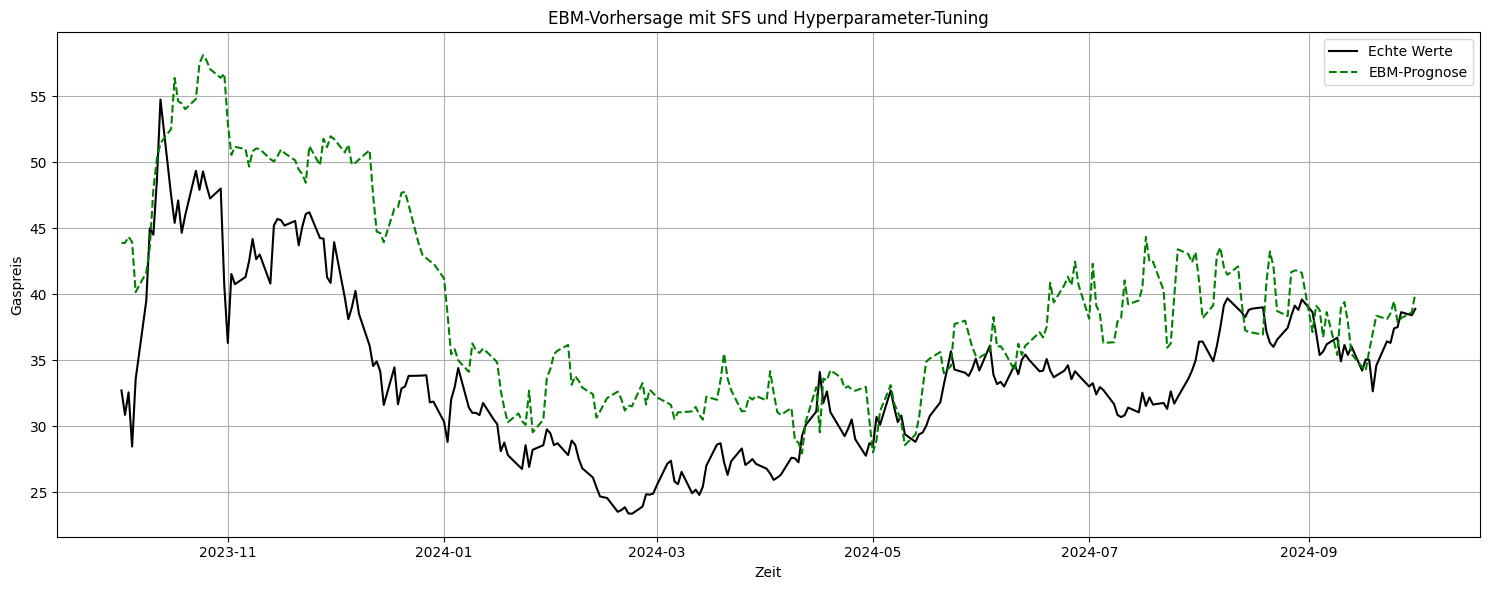

In [43]:

# 1) Zeitreihen-Cross-Validation definieren
"""tscv = TimeSeriesSplit(n_splits=4)

# 2) Basismodell für Feature Selection: Explainable Boosting Machine
ebm_base = ExplainableBoostingRegressor(random_state=42)

# 3) Sequential Forward Selection mit EBM
sfs_ebm = SequentialFeatureSelector(
    estimator=ebm_base,
    n_features_to_select=8,
    direction='forward',
    scoring='neg_mean_absolute_error',
    cv=tscv,
    n_jobs=-1
)
sfs_ebm.fit(train_df, train_y_df.values.ravel())

# 

# 5) Ausgewählte Features extrahieren
selected_features_ebm = list(sfs_ebm.get_feature_names_out())
print("Ausgewählte Features (EBM):", selected_features_ebm)"""
catboost_model = CatBoostRegressor(iterations=100,  # Anpassbare Parameter
                                   learning_rate=0.03,
                                   depth=6,
                                   loss_function='MAE',
                                   eval_metric='MAE',
                                   random_seed=42,
                                   verbose=0)

catboost_model.fit(train_df, train_y_df.values.ravel())
feature_importances = catboost_model.get_feature_importance()
importance_df = pd.DataFrame({'Feature': train_df.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

n_top_features_cb = 10  # Wähle die Top 10 Features (anpassbar)
selected_features_ebm = importance_df['Feature'].head(n_top_features_cb).tolist()
print("Durch CatBoost Feature Importance ausgewählte Features:", selected_features_cb)
#selected_features_ebm = ['S-Gas DA D', 'K-Wind speed_rollmin_7', 'N-Demand LDZ_lag7', 'N-Demand LDZ_rollstd_30', 'S-Gas DA D_rollmean_3', 'S-Gas DA D_rollmin_7', 'S-Gas DA D_rollmax_7', 'S-Oil Spot Price (Brent)_lag1', 'S-Oil Spot Price (Brent)_rollmean_3', 'S-Oil Spot Price (Brent)_rollmax_7', 'S-CO2 Price_rollstd_30', 'Season_Summer', 'Season_Winter']
# 6) Trainings- und Testdaten mit selektierten Features
X_train_ebm = unscaled_train_final_df[selected_features_ebm]
X_test_ebm  = unscaled_test_final_df[selected_features_ebm]
y_train = unscaled_train_y_df.values.ravel()
y_test  = unscaled_test_y_df.values.ravel()


param_grid_ebm = {
    'max_bins': [256, 512],  # Oft gute Standardwerte
    'max_leaves': [64, 128, 256], # Etwas feiner abgestuft
    'interactions': [1, 3, 5],   # Fokus auf das Vorhandensein von Interaktionen
    'outer_bags': [16, 20],      # Eingegrenzter Bereich
    'inner_bags': [8, 10],       # Eingegrenzter Bereich
    'learning_rate': [0.0005, 0.001, 0.005], # Feiner abgestufte Lernraten
    'max_rounds': [300, 400, 500], # Um den vorherigen Bereich zu erkunden
    'early_stopping_rounds': [15, 20], # Etwas konservativer
    'validation_size': [0.15, 0.2] # Zwischen den vorherigen Werten
}

random_search = RandomizedSearchCV(
    estimator=ExplainableBoostingRegressor(random_state=42),
    param_distributions=param_dist_ebm_angepasst,
    n_iter=20,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_ebm, y_train)

# Bestes Modell:
best_ebm = random_search.best_estimator_
print("Beste Hyperparameter (EBM):", random_search.best_params_)

y_pred = best_ebm.predict(X_test_ebm)


# 10) Performance-Metriken
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE (EBM): {mae:.4f}")
print(f"RMSE (EBM): {rmse:.4f}")
print(f"R² (EBM): {r2:.4f}")

# 11) Plot der Prognose
plt.figure(figsize=(15, 6))
plt.plot(test_y_df.index, y_test, label='Echte Werte', color='black')
plt.plot(test_y_df.index, y_pred, label='EBM-Prognose', linestyle='--', color='green')
plt.title('EBM-Vorhersage mit SFS und Hyperparameter-Tuning')
plt.xlabel('Zeit')
plt.ylabel('Gaspreis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
